In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.io
import gc
import datetime
import time
import mat73
import random
import matplotlib
import _spin_params as spin_pars
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import prepare_solution, remake_julia_problem, clean_julia, format_julia_sol_2ndorder, solve_julia_problem, tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left, find_nearest_sorted, smooth_data
from _steady_state import a_steady, a_steady_with_sz
from _mbes import mbes, mbes_soc, mbes_no_cavity, mbes_soc_no_cavity
from _do_calculation import solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_mbes_general
from _do_calculation import setup_mbes, test_mbes_2ndorder, setup_mbes_2ndorder, solve_mbes_2ndorder, solve_mbes_general, solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_obes
from _mbes import mbes, mbes_soc, mbes_soc_no_cavity, mbes_soc_det, obes_soc, mbes_2ndorder
from julia import Main
# matplotlib.pyplot.switch_backend('nbagg')
%qtconsole

In [ ]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins  # 701#5000#20
nbins = 351
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse


def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002) * \
        (1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse


def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    #xint = np.linspace(0, tend, nfcomps)

    #spline = interpolate.BSpline(xint, fcomps, 2)
    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)

    #spline = spline/nfcomps
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004) * \
        (1-logistic.cdf(t, loc=tend-0.02, scale=0.004))

    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq

In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

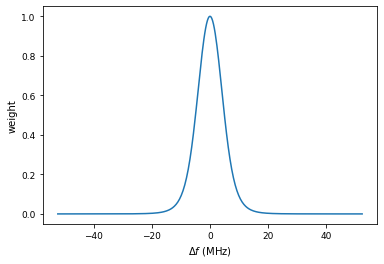

Cooperativity is: 9.264745


In [5]:
plt.close('all')
matplotlib.interactive(False)
spins, gs, pdf = create_spins_inhomo_g(
    gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight')
plt.show()
# %qtconsole
coop = gcoll**2/kappa*np.sum(pdf/(gperp+1j*2*np.pi*spins))
print("Cooperativity is: %f" % coop.real)

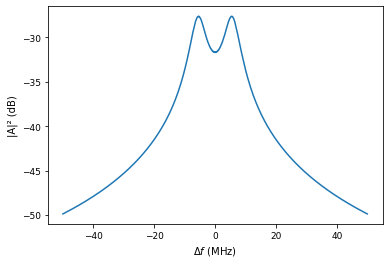

In [6]:
plt.close('all')
matplotlib.interactive(False)

initsteady = (0.001, 0.001)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)')
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
plt.show()
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [7]:
pumptime = 52e-3  # 5*np.pi/gcoll
decaytime = 500e-3
dt = 0.0005
numsteps = int(pumptime/dt)
tlist = np.arange(0, pumptime+dt, dt)
tlistdecay = np.arange(0, decaytime+dt, dt)


# test time it takes to calculate


init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1:len(spins)+1] = 0

### Simulate Driving

In [8]:
filepath = """/mnt/samba2/experiments/Quantum InterConnect/Cryogenics/Dilution Fridge/Measurements/20210713_DCR_e-diamond_17/timeResolved/ScanPumpAttn1/SCRIPT_1/scan_pumpAttn_rectPulse_50ns_1-2.mat"""
try:
    data_ps = mat73.loadmat(filepath)
except TypeError:
    data_ps = scipy.io.loadmat(filepath, simplify_cells=True)
scan_values_ps = data_ps['scan_values']

iq_data_ps = np.zeros(
    (len(data_ps['IQdata_scan']), *np.shape(data_ps['IQdata_scan'][0])))

for i in range(len(data_ps['IQdata_scan'])):
    iq_data_ps[i, :, :] = data_ps['IQdata_scan'][i]

pl_idx = 4000
idx_s = 1800+165
p_end = -16

hori = float(data_ps['pars']['acqiris']['acqirisStruct']
             ['horizontal']['sampInterval'])*1e9

idx = find_nearest(-scan_values_ps, p_end)

a2plot = (iq_data_ps[:idx, idx_s:pl_idx, 0]**2 +
          iq_data_ps[:idx, idx_s:pl_idx, 1]**2)
aplotr = iq_data_ps[:idx, idx_s:pl_idx, 0]
aploti = iq_data_ps[:idx, idx_s:pl_idx, 1]
t = np.linspace(0, len(a2plot[0])*hori, len(a2plot[0]))
ilist_exp, qlist_exp = data_ps['measPars_scan'][0]['pump']['waveform']
tpump = np.arange(0, len(ilist_exp)*dt, dt)

In [35]:
pin = np.arange(-23.5, -16.5, 0.5)
aref = 940
testphase = -np.pi/2*1.1
# %qtconsole
alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
alosr = np.zeros(alos.shape)
alosi = np.zeros(alos.shape)
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))
setup_mbes(
    mbes, init, pdf, tlist, tlistdecay, aref, kappa, deltac, gs, gperp, spins, gpar)
for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    remake_julia_problem(params=(dr,))
    sol = solve_julia_problem(tlist, tlistdecay)
    asolpump = prepare_solution(sol[:len(tlist)], init, pdf, tlist)
    asoldecay = prepare_solution(sol[-len(tlistdecay):], init, pdf, tlistdecay)
    # asolpump, asoldecay, infodict = solve_mbes(
    #    mbes, init, pdf, tlist, tlistdecay, dr, kappa, deltac, gs, gperp, spins, gpar)
    alos[ctr, :] = np.hstack((abs(asolpump[:, 0])**2, abs(asoldecay[:, 0])**2))
    alosr[ctr, :] = np.hstack((asolpump[:, 0].real, asoldecay[:, 0].real))
    alosi[ctr, :] = np.hstack((asolpump[:, 0].imag, asoldecay[:, 0].imag))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(
        np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack(
        (np.real(asolpump[:, 2::2]), np.real(asoldecay[:, 2::2])))
    small[ctr, :, :] = np.vstack(
        (np.real(asolpump[:, 1::2]), np.real(asoldecay[:, 1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(
        np.sum(asoldecay[:, 1::2], axis=1))))
clean_julia()
Main.problem = None
clean_julia()

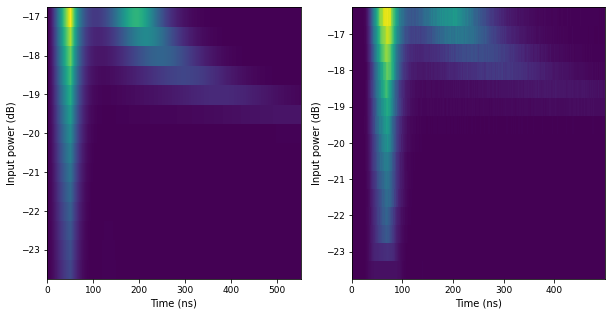

In [36]:
plt.close('all')
matplotlib.interactive(False)
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pcolor(tplot, pin, alos, shading="auto")
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)')

ax2.pcolor(t[:1000], -scan_values_ps[:idx], a2plot[:, :1000], shading='auto')
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)')
maxAmpl = abs(asolpump).max()
plt.show()

In [37]:
init2nd = np.zeros(5*(len(spins)*(len(spins)-1))//2+len(spins)*5+3)
init2nd[(nbins*4+3):(nbins*5+3)] = -1.
init2nd[(nbins*5+3)+2*nbins*(nbins-1):(nbins*5+3) +
        2*nbins*(nbins-1)+nbins*(nbins-1)//2] = 1.
initpump = np.asarray(init2nd, dtype=np.complex128)
alos2nd = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
gc.collect()
for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    setup_mbes_2ndorder(mbes_2ndorder, initpump, pdf, tlist, tlistdecay,
                        gs, dr, kappa, gperp, gpar, spins, deltac)
    sol = solve_julia_problem(tlist, tlistdecay)
    pumplos, decaylos = format_julia_sol_2ndorder(
        sol, tlist, tlistdecay, init2nd, pdf)
    alos2nd[ctr, :] = np.hstack(
        (abs(pumplos[:, 0])**2, abs(decaylos[:, 0])**2))
    print("Done with %i from %i" % (ctr+1, len(pin)), end="\r")
    clean_julia()
gc.collect()
clean_julia()
Main.problem = None
clean_julia()

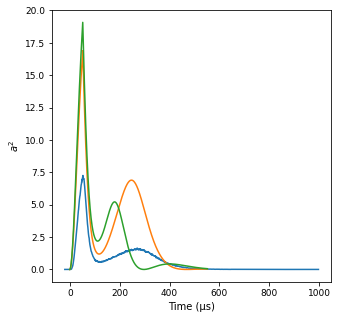

In [38]:
plt.close('all')
matplotlib.interactive(False)
target_p = -18
ratio = 3.2
pretime = -20

idx_sim = find_nearest(pin, target_p)
idx_exp = find_nearest(-scan_values_ps, target_p)

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
ax1.plot(t+pretime, smooth_data(a2plot[idx_exp], 5)*ratio)
ax1.plot(tplot, alos[idx_sim])
ax1.plot(tplot, alos2nd[idx_sim+1])
ax1.set_xlabel("Time (µs)")
ax1.set_ylabel("$a^2$")
plt.show()

# %qtconsole
#ax4.plot(tplot+pretime, szlos[idx_sim])
# %qtconsole

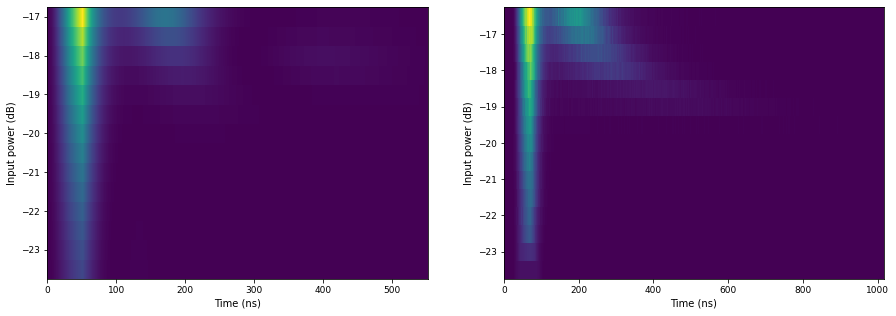

In [39]:
plt.close('all')
matplotlib.interactive(False)

tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.pcolor(tplot, pin, alos2nd, shading="auto")
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)')

ax2.pcolor(t, -scan_values_ps[:idx], a2plot, shading='auto')
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)')
maxAmpl = abs(asolpump).max()
plt.show()